In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from global_config import RANDOM_SEED, FOLDER_DATA_AUGMENTATION, USER_IDS
from utils import load, plot

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
TEST_SIZE = 0.3

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FOLDER_MODELS = '../models/autoencoders_requirements/'
FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_11-19_51_02.h5'

In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

In [4]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', recall, precision, f1]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    
    list_callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor='val_accuracy', verbose=1, save_best_only=True)
    ]
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.set_tag("requirements", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def plot_metrics(y_true, y_pred, hist):
    print(' Final Accuracy: {:=6.2f}%'.format(accuracy_score(y_true, y_pred) * 100))
    print('Final F-measure: {:=6.2f}%'.format(f1_score(y_true, y_pred) * 100))
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)


def train_requirement_branch(base_model, input_folder, name, get_req_value):
    mrk_files = load.mrk_files_from_folder(input_folder)
    img_files = [mrk.filepath.replace('.mrk', '.png') for mrk in mrk_files]
    
    if len(mrk_files) == 0:
        print(f"there are no data to train {name} requirement")
        return None

    x = load.images_from_list_files(img_files)
    y = np.array([get_req_value(mrk) for mrk in mrk_files])
    
    x_train, x_val, y_train, y_val = train_test_split(
        x / 255.0, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
list_model_files = []

#### 2. Blurred

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 19s 3ms/step - loss: 0.5186 - accuracy: 0.7226 - recall: 0.6402 - precision: 0.7862 - f1: 0.6894 - val_loss: 0.5161 - val_accuracy: 0.7290 - val_recall: 0.6492 - val_precision: 0.7742 - val_f1: 0.6997

Epoch 00001: val_accuracy improved from -inf to 0.72900, saving model to ../models/autoencoders_requirements/blurred_2020_03_14-18_57_01.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4780 - accuracy: 0.7363 - recall: 0.6414 - precision: 0.8118 - f1: 0.7024 - val_loss: 0.5399 - val_accuracy: 0.7270 - val_recall: 0.5245 - val_precision: 0.8848 - val_f1: 0.6495

Epoch 00002: val_accuracy did not improve from 0.72900
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4695 - accuracy: 0.7460 - recall: 0.6515 - precision: 0.8285 - f1: 0.7115 - val_loss: 0.5006 - val_accuracy: 0.7127 - val_recall: 0.7592 - val_precision: 0.696


Epoch 00026: val_accuracy did not improve from 0.72900
Epoch 27/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3952 - accuracy: 0.8126 - recall: 0.7605 - precision: 0.8525 - f1: 0.7964 - val_loss: 0.5487 - val_accuracy: 0.7150 - val_recall: 0.8839 - val_precision: 0.6632 - val_f1: 0.7523

Epoch 00027: val_accuracy did not improve from 0.72900
Epoch 28/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3938 - accuracy: 0.8153 - recall: 0.7656 - precision: 0.8572 - f1: 0.8018 - val_loss: 0.5572 - val_accuracy: 0.7203 - val_recall: 0.8227 - val_precision: 0.6829 - val_f1: 0.7403

Epoch 00028: val_accuracy did not improve from 0.72900
Epoch 29/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3930 - accuracy: 0.8117 - recall: 0.7627 - precision: 0.8514 - f1: 0.7970 - val_loss: 0.5601 - val_accuracy: 0.7087 - val_recall: 0.8700 - val_precision: 0.6579 - val_f1: 0.7438

Epoch 00029: val_accuracy did not improve from 0.72900

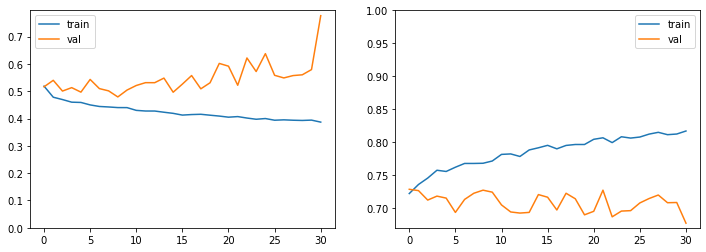

In [8]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/2-blurred/', 
    'blurred',
    lambda mrk: mrk.photo_reqs.blurred.value
)
list_model_files.append(model_file)

#### 3. Looking Away

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.6793 - accuracy: 0.5691 - recall: 0.5628 - precision: 0.5714 - f1: 0.5399 - val_loss: 0.6726 - val_accuracy: 0.5827 - val_recall: 0.5110 - val_precision: 0.5997 - val_f1: 0.5411

Epoch 00001: val_accuracy improved from -inf to 0.58267, saving model to ../models/autoencoders_requirements/looking_away_2020_03_14-19_06_43.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6705 - accuracy: 0.5919 - recall: 0.6112 - precision: 0.5941 - f1: 0.5883 - val_loss: 0.6682 - val_accuracy: 0.5903 - val_recall: 0.5056 - val_precision: 0.6119 - val_f1: 0.5433

Epoch 00002: val_accuracy improved from 0.58267 to 0.59033, saving model to ../models/autoencoders_requirements/looking_away_2020_03_14-19_06_43.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6709 - accuracy: 0.5926 - recall: 0.6126 - precision: 0.5963 

7000/7000 [==============================] - 15s 2ms/step - loss: 0.5753 - accuracy: 0.6961 - recall: 0.7101 - precision: 0.6971 - f1: 0.6923 - val_loss: 0.6289 - val_accuracy: 0.6370 - val_recall: 0.5136 - val_precision: 0.6755 - val_f1: 0.5769

Epoch 00048: val_accuracy did not improve from 0.68100
Epoch 49/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5750 - accuracy: 0.6930 - recall: 0.7004 - precision: 0.6918 - f1: 0.6867 - val_loss: 0.6088 - val_accuracy: 0.6627 - val_recall: 0.6129 - val_precision: 0.6762 - val_f1: 0.6376

Epoch 00049: val_accuracy did not improve from 0.68100
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5788 - accuracy: 0.6903 - recall: 0.6914 - precision: 0.6946 - f1: 0.6823 - val_loss: 0.7012 - val_accuracy: 0.6093 - val_recall: 0.3640 - val_precision: 0.7062 - val_f1: 0.4721

Epoch 00050: val_accuracy did not improve from 0.68100
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/st

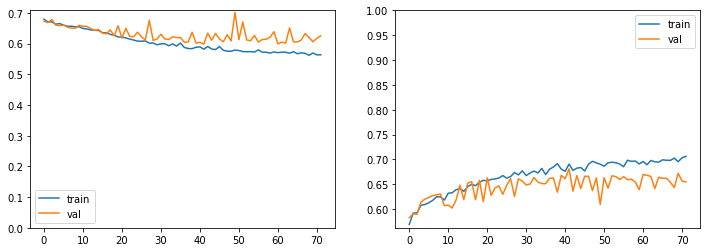

In [9]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/3-looking_away/', 
    'looking_away',
    lambda mrk: mrk.photo_reqs.looking_away.value
)
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/4-ink_marked_creased/', 
    'ink_marked_creased',
    lambda mrk: mrk.photo_reqs.ink_marked_creased.value
)
list_model_files.append(model_file)


there are no data to train ink_marked_creased requirement


#### 5. Unnatural Skin Tone 

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.6378 - accuracy: 0.6351 - recall: 0.6768 - precision: 0.6314 - f1: 0.6276 - val_loss: 0.6067 - val_accuracy: 0.6777 - val_recall: 0.9100 - val_precision: 0.6206 - val_f1: 0.7334

Epoch 00001: val_accuracy improved from -inf to 0.67767, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_14-19_26_28.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6006 - accuracy: 0.6719 - recall: 0.7510 - precision: 0.6555 - f1: 0.6797 - val_loss: 0.5641 - val_accuracy: 0.7213 - val_recall: 0.7946 - val_precision: 0.6906 - val_f1: 0.7338

Epoch 00002: val_accuracy improved from 0.67767 to 0.72133, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_14-19_26_28.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5781 - accuracy: 0.6900 - recall: 0.7924 - prec


Epoch 00024: val_accuracy did not improve from 0.76333
Epoch 25/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4868 - accuracy: 0.7496 - recall: 0.8057 - precision: 0.7283 - f1: 0.7573 - val_loss: 0.4749 - val_accuracy: 0.7690 - val_recall: 0.8104 - val_precision: 0.7457 - val_f1: 0.7715

Epoch 00025: val_accuracy improved from 0.76333 to 0.76900, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_14-19_26_28.h5
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4872 - accuracy: 0.7506 - recall: 0.8025 - precision: 0.7312 - f1: 0.7560 - val_loss: 0.5634 - val_accuracy: 0.6820 - val_recall: 0.4269 - val_precision: 0.8733 - val_f1: 0.5647

Epoch 00026: val_accuracy did not improve from 0.76900
Epoch 27/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4887 - accuracy: 0.7523 - recall: 0.8029 - precision: 0.7356 - f1: 0.7584 - val_loss: 0.5083 - val_accuracy: 0.7370 - val_recall: 0.8


Epoch 00049: val_accuracy improved from 0.77400 to 0.77433, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_14-19_26_28.h5
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4683 - accuracy: 0.7696 - recall: 0.8090 - precision: 0.7565 - f1: 0.7710 - val_loss: 0.4888 - val_accuracy: 0.7430 - val_recall: 0.6873 - val_precision: 0.7696 - val_f1: 0.7193

Epoch 00050: val_accuracy did not improve from 0.77433
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4598 - accuracy: 0.7746 - recall: 0.8100 - precision: 0.7608 - f1: 0.7761 - val_loss: 0.4702 - val_accuracy: 0.7583 - val_recall: 0.8091 - val_precision: 0.7335 - val_f1: 0.7634

Epoch 00051: val_accuracy did not improve from 0.77433
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4604 - accuracy: 0.7744 - recall: 0.8044 - precision: 0.7652 - f1: 0.7740 - val_loss: 0.4735 - val_accuracy: 0.7640 - val_recall: 0.7


Epoch 00099: val_accuracy did not improve from 0.78333
Epoch 100/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4188 - accuracy: 0.7959 - recall: 0.8087 - precision: 0.7905 - f1: 0.7919 - val_loss: 0.4444 - val_accuracy: 0.7817 - val_recall: 0.8103 - val_precision: 0.7668 - val_f1: 0.7828

Epoch 00100: val_accuracy did not improve from 0.78333
 Final Accuracy:  78.17%
Final F-measure:  78.75%
[[1131  369]
 [ 286 1214]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1500
           1       0.77      0.81      0.79      1500

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



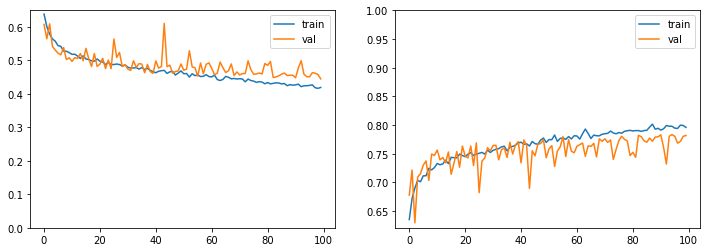

In [11]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/5-unnatural_skin_tone/', 
    'unnatural_skin_tone',
    lambda mrk: mrk.photo_reqs.unnatural_skin_tone.value
)
list_model_files.append(model_file)

#### 6. Too Dark/Light 

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.5726 - accuracy: 0.7124 - recall: 0.7268 - precision: 0.7214 - f1: 0.7069 - val_loss: 0.4974 - val_accuracy: 0.7773 - val_recall: 0.7833 - val_precision: 0.7738 - val_f1: 0.7737

Epoch 00001: val_accuracy improved from -inf to 0.77733, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_14-19_53_12.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5143 - accuracy: 0.7583 - recall: 0.7714 - precision: 0.7638 - f1: 0.7550 - val_loss: 0.5125 - val_accuracy: 0.7540 - val_recall: 0.6093 - val_precision: 0.8606 - val_f1: 0.7053

Epoch 00002: val_accuracy did not improve from 0.77733
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4907 - accuracy: 0.7724 - recall: 0.7749 - precision: 0.7837 - f1: 0.7667 - val_loss: 0.5805 - val_accuracy: 0.7077 - val_recall: 0.4740 - val_precision

7000/7000 [==============================] - 15s 2ms/step - loss: 0.3789 - accuracy: 0.8353 - recall: 0.8400 - precision: 0.8337 - f1: 0.8306 - val_loss: 0.4385 - val_accuracy: 0.8153 - val_recall: 0.7024 - val_precision: 0.9085 - val_f1: 0.7855

Epoch 00051: val_accuracy improved from 0.80567 to 0.81533, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_14-19_53_12.h5
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3871 - accuracy: 0.8290 - recall: 0.8365 - precision: 0.8265 - f1: 0.8254 - val_loss: 0.5906 - val_accuracy: 0.7460 - val_recall: 0.5325 - val_precision: 0.9336 - val_f1: 0.6680

Epoch 00052: val_accuracy did not improve from 0.81533
Epoch 53/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3873 - accuracy: 0.8221 - recall: 0.8336 - precision: 0.8189 - f1: 0.8205 - val_loss: 0.6451 - val_accuracy: 0.7243 - val_recall: 0.4778 - val_precision: 0.9486 - val_f1: 0.6237

Epoch 00053: val_accuracy di


Epoch 00076: val_accuracy did not improve from 0.81533
Epoch 77/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3611 - accuracy: 0.8380 - recall: 0.8482 - precision: 0.8359 - f1: 0.8339 - val_loss: 0.5316 - val_accuracy: 0.7867 - val_recall: 0.6264 - val_precision: 0.9242 - val_f1: 0.7391

Epoch 00077: val_accuracy did not improve from 0.81533
Epoch 78/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3570 - accuracy: 0.8476 - recall: 0.8558 - precision: 0.8455 - f1: 0.8451 - val_loss: 0.5285 - val_accuracy: 0.7850 - val_recall: 0.6231 - val_precision: 0.9270 - val_f1: 0.7374

Epoch 00078: val_accuracy did not improve from 0.81533
Epoch 79/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3539 - accuracy: 0.8441 - recall: 0.8541 - precision: 0.8412 - f1: 0.8422 - val_loss: 0.5034 - val_accuracy: 0.7987 - val_recall: 0.6673 - val_precision: 0.9084 - val_f1: 0.7626

Epoch 00079: val_accuracy did not improve from 0.81533

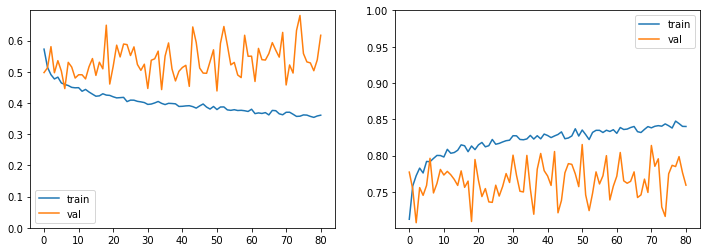

In [12]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/6-too_dark_light/', 
    'too_dark_light',
    lambda mrk: mrk.photo_reqs.too_dark_light.value
)
list_model_files.append(model_file)

#### 7. Washed Out

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.4382 - accuracy: 0.7957 - recall: 0.7463 - precision: 0.8424 - f1: 0.7775 - val_loss: 0.3418 - val_accuracy: 0.8587 - val_recall: 0.8430 - val_precision: 0.8678 - val_f1: 0.8513

Epoch 00001: val_accuracy improved from -inf to 0.85867, saving model to ../models/autoencoders_requirements/washed_out_2020_03_14-20_15_11.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3265 - accuracy: 0.8554 - recall: 0.8682 - precision: 0.8515 - f1: 0.8518 - val_loss: 0.2969 - val_accuracy: 0.8457 - val_recall: 0.7719 - val_precision: 0.9070 - val_f1: 0.8290

Epoch 00002: val_accuracy did not improve from 0.85867
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2669 - accuracy: 0.8877 - recall: 0.9096 - precision: 0.8738 - f1: 0.8866 - val_loss: 0.3334 - val_accuracy: 0.8297 - val_recall: 0.7367 - val_precision: 0.

7000/7000 [==============================] - 15s 2ms/step - loss: 0.1016 - accuracy: 0.9609 - recall: 0.9599 - precision: 0.9632 - f1: 0.9597 - val_loss: 0.1096 - val_accuracy: 0.9610 - val_recall: 0.9505 - val_precision: 0.9677 - val_f1: 0.9578

Epoch 00024: val_accuracy improved from 0.95133 to 0.96100, saving model to ../models/autoencoders_requirements/washed_out_2020_03_14-20_15_11.h5
Epoch 25/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1040 - accuracy: 0.9601 - recall: 0.9597 - precision: 0.9624 - f1: 0.9593 - val_loss: 0.1407 - val_accuracy: 0.9547 - val_recall: 0.9370 - val_precision: 0.9688 - val_f1: 0.9512

Epoch 00025: val_accuracy did not improve from 0.96100
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1009 - accuracy: 0.9621 - recall: 0.9565 - precision: 0.9680 - f1: 0.9606 - val_loss: 0.1512 - val_accuracy: 0.9440 - val_recall: 0.9092 - val_precision: 0.9767 - val_f1: 0.9399

Epoch 00026: val_accuracy did no

7000/7000 [==============================] - 15s 2ms/step - loss: 0.0653 - accuracy: 0.9754 - recall: 0.9697 - precision: 0.9808 - f1: 0.9743 - val_loss: 0.1186 - val_accuracy: 0.9613 - val_recall: 0.9378 - val_precision: 0.9832 - val_f1: 0.9588

Epoch 00074: val_accuracy did not improve from 0.96867
Epoch 75/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.0569 - accuracy: 0.9806 - recall: 0.9762 - precision: 0.9852 - f1: 0.9800 - val_loss: 0.1408 - val_accuracy: 0.9573 - val_recall: 0.9227 - val_precision: 0.9906 - val_f1: 0.9540

Epoch 00075: val_accuracy did not improve from 0.96867
Epoch 76/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.0552 - accuracy: 0.9791 - recall: 0.9748 - precision: 0.9834 - f1: 0.9783 - val_loss: 0.1140 - val_accuracy: 0.9580 - val_recall: 0.9622 - val_precision: 0.9518 - val_f1: 0.9561

Epoch 00076: val_accuracy did not improve from 0.96867
Epoch 77/100
7000/7000 [==============================] - 15s 2ms/st


Epoch 00099: val_accuracy did not improve from 0.97267
Epoch 100/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.0521 - accuracy: 0.9806 - recall: 0.9781 - precision: 0.9829 - f1: 0.9798 - val_loss: 0.1234 - val_accuracy: 0.9657 - val_recall: 0.9348 - val_precision: 0.9972 - val_f1: 0.9640

Epoch 00100: val_accuracy did not improve from 0.97267
 Final Accuracy:  96.57%
Final F-measure:  96.45%
[[1496    4]
 [  99 1401]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1500
           1       1.00      0.93      0.96      1500

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



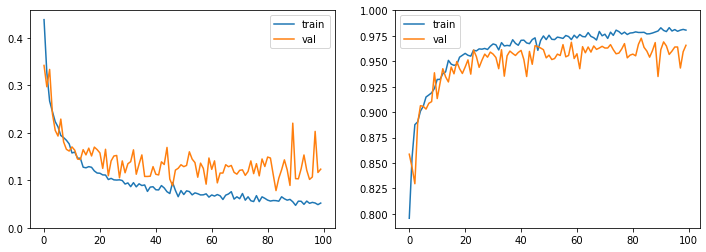

In [13]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/7-washed_out/', 
    'washed_out',
    lambda mrk: mrk.photo_reqs.washed_out.value
)
list_model_files.append(model_file)

#### *8. Pixelation*

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.6559 - accuracy: 0.6160 - recall: 0.5956 - precision: 0.6374 - f1: 0.5964 - val_loss: 0.6523 - val_accuracy: 0.6327 - val_recall: 0.4238 - val_precision: 0.7294 - val_f1: 0.5257

Epoch 00001: val_accuracy improved from -inf to 0.63267, saving model to ../models/autoencoders_requirements/pixelation_2020_03_14-20_41_52.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6362 - accuracy: 0.6533 - recall: 0.6034 - precision: 0.6786 - f1: 0.6243 - val_loss: 0.6700 - val_accuracy: 0.6017 - val_recall: 0.2918 - val_precision: 0.7766 - val_f1: 0.4142

Epoch 00002: val_accuracy did not improve from 0.63267
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6281 - accuracy: 0.6604 - recall: 0.6091 - precision: 0.6889 - f1: 0.6323 - val_loss: 0.6241 - val_accuracy: 0.6567 - val_recall: 0.6054 - val_precision: 0.

7000/7000 [==============================] - 15s 2ms/step - loss: 0.5335 - accuracy: 0.7313 - recall: 0.6771 - precision: 0.7648 - f1: 0.7079 - val_loss: 0.5985 - val_accuracy: 0.6777 - val_recall: 0.7000 - val_precision: 0.6679 - val_f1: 0.6774

Epoch 00050: val_accuracy did not improve from 0.70400
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5289 - accuracy: 0.7361 - recall: 0.6851 - precision: 0.7645 - f1: 0.7137 - val_loss: 0.6442 - val_accuracy: 0.6683 - val_recall: 0.7901 - val_precision: 0.6367 - val_f1: 0.6986

Epoch 00051: val_accuracy did not improve from 0.70400
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5301 - accuracy: 0.7367 - recall: 0.6935 - precision: 0.7634 - f1: 0.7176 - val_loss: 0.5837 - val_accuracy: 0.6873 - val_recall: 0.6315 - val_precision: 0.7115 - val_f1: 0.6616

Epoch 00052: val_accuracy did not improve from 0.70400
Epoch 53/100
7000/7000 [==============================] - 15s 2ms/st

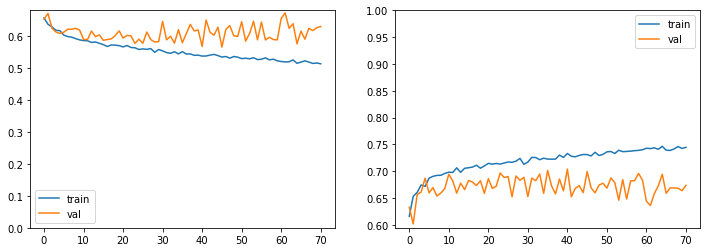

In [14]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/8-pixelation/', 
    'pixelation',
    lambda mrk: mrk.photo_reqs.pixelation.value
)
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.5802 - accuracy: 0.7153 - recall: 0.6383 - precision: 0.7696 - f1: 0.6826 - val_loss: 0.5436 - val_accuracy: 0.7697 - val_recall: 0.6997 - val_precision: 0.8127 - val_f1: 0.7459

Epoch 00001: val_accuracy improved from -inf to 0.76967, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_14-21_01_48.h5
Epoch 2/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.5593 - accuracy: 0.7376 - recall: 0.6674 - precision: 0.7799 - f1: 0.7107 - val_loss: 0.5456 - val_accuracy: 0.7423 - val_recall: 0.6011 - val_precision: 0.8354 - val_f1: 0.6921

Epoch 00002: val_accuracy did not improve from 0.76967
Epoch 3/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.5549 - accuracy: 0.7406 - recall: 0.6759 - precision: 0.7823 - f1: 0.7155 - val_loss: 0.5191 - val_accuracy: 0.7760 - val_recall: 0.7129 - val_precisi


Epoch 00025: val_accuracy did not improve from 0.78633
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5011 - accuracy: 0.7714 - recall: 0.7559 - precision: 0.7858 - f1: 0.7628 - val_loss: 0.4899 - val_accuracy: 0.7807 - val_recall: 0.7422 - val_precision: 0.7999 - val_f1: 0.7648

Epoch 00026: val_accuracy did not improve from 0.78633
Epoch 27/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4986 - accuracy: 0.7714 - recall: 0.7576 - precision: 0.7801 - f1: 0.7614 - val_loss: 0.4892 - val_accuracy: 0.7817 - val_recall: 0.7397 - val_precision: 0.8053 - val_f1: 0.7652

Epoch 00027: val_accuracy did not improve from 0.78633
Epoch 28/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5014 - accuracy: 0.7673 - recall: 0.7487 - precision: 0.7810 - f1: 0.7577 - val_loss: 0.4877 - val_accuracy: 0.7827 - val_recall: 0.7546 - val_precision: 0.7959 - val_f1: 0.7695

Epoch 00028: val_accuracy did not improve from 0.78633

7000/7000 [==============================] - 15s 2ms/step - loss: 0.4808 - accuracy: 0.7826 - recall: 0.7642 - precision: 0.7943 - f1: 0.7721 - val_loss: 0.5124 - val_accuracy: 0.7540 - val_recall: 0.8660 - val_precision: 0.7074 - val_f1: 0.7734

Epoch 00051: val_accuracy did not improve from 0.79067
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4807 - accuracy: 0.7824 - recall: 0.7701 - precision: 0.7940 - f1: 0.7744 - val_loss: 0.4878 - val_accuracy: 0.7877 - val_recall: 0.7213 - val_precision: 0.8277 - val_f1: 0.7654

Epoch 00052: val_accuracy did not improve from 0.79067
Epoch 53/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4779 - accuracy: 0.7817 - recall: 0.7709 - precision: 0.7924 - f1: 0.7752 - val_loss: 0.4933 - val_accuracy: 0.7837 - val_recall: 0.7037 - val_precision: 0.8339 - val_f1: 0.7574

Epoch 00053: val_accuracy did not improve from 0.79067
Epoch 54/100
7000/7000 [==============================] - 15s 2ms/st

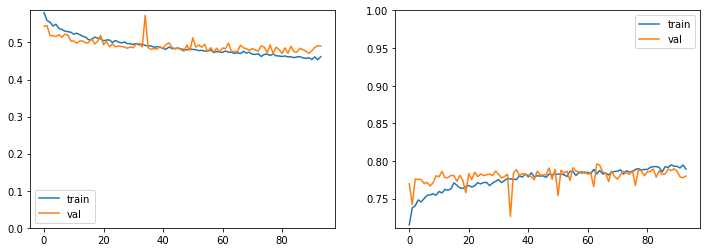

In [15]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/9-hair_across_eyes/', 
    'hair_across_eyes',
    lambda mrk: mrk.photo_reqs.hair_across_eyes.value
)
list_model_files.append(model_file)

#### 10. Eyes Closed  

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.6608 - accuracy: 0.6103 - recall: 0.4838 - precision: 0.6528 - f1: 0.5413 - val_loss: 0.6537 - val_accuracy: 0.6227 - val_recall: 0.4537 - val_precision: 0.6855 - val_f1: 0.5363

Epoch 00001: val_accuracy improved from -inf to 0.62267, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_14-21_27_09.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6543 - accuracy: 0.6246 - recall: 0.5049 - precision: 0.6703 - f1: 0.5628 - val_loss: 0.6482 - val_accuracy: 0.6263 - val_recall: 0.4758 - val_precision: 0.6789 - val_f1: 0.5495

Epoch 00002: val_accuracy improved from 0.62267 to 0.62633, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_14-21_27_09.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6516 - accuracy: 0.6300 - recall: 0.5132 - precision: 0.6763 - 

7000/7000 [==============================] - 15s 2ms/step - loss: 0.5884 - accuracy: 0.6923 - recall: 0.6897 - precision: 0.6990 - f1: 0.6840 - val_loss: 0.5920 - val_accuracy: 0.6917 - val_recall: 0.6373 - val_precision: 0.7180 - val_f1: 0.6670

Epoch 00024: val_accuracy improved from 0.68767 to 0.69167, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_14-21_27_09.h5
Epoch 25/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5896 - accuracy: 0.6857 - recall: 0.6871 - precision: 0.6929 - f1: 0.6786 - val_loss: 0.5919 - val_accuracy: 0.6893 - val_recall: 0.6276 - val_precision: 0.7163 - val_f1: 0.6604

Epoch 00025: val_accuracy did not improve from 0.69167
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5873 - accuracy: 0.6879 - recall: 0.6890 - precision: 0.6945 - f1: 0.6790 - val_loss: 0.6084 - val_accuracy: 0.6737 - val_recall: 0.5556 - val_precision: 0.7300 - val_f1: 0.6212

Epoch 00026: val_accuracy did n

7000/7000 [==============================] - 15s 2ms/step - loss: 0.5546 - accuracy: 0.7130 - recall: 0.7179 - precision: 0.7150 - f1: 0.7073 - val_loss: 0.5933 - val_accuracy: 0.6977 - val_recall: 0.6992 - val_precision: 0.6989 - val_f1: 0.6915

Epoch 00049: val_accuracy did not improve from 0.70600
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5598 - accuracy: 0.7029 - recall: 0.7156 - precision: 0.7046 - f1: 0.6984 - val_loss: 0.5856 - val_accuracy: 0.6930 - val_recall: 0.7132 - val_precision: 0.6889 - val_f1: 0.6928

Epoch 00050: val_accuracy did not improve from 0.70600
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5596 - accuracy: 0.7094 - recall: 0.7091 - precision: 0.7151 - f1: 0.7009 - val_loss: 0.5802 - val_accuracy: 0.6923 - val_recall: 0.7721 - val_precision: 0.6680 - val_f1: 0.7085

Epoch 00051: val_accuracy did not improve from 0.70600
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/st

7000/7000 [==============================] - 15s 2ms/step - loss: 0.5118 - accuracy: 0.7331 - recall: 0.7364 - precision: 0.7313 - f1: 0.7270 - val_loss: 0.6113 - val_accuracy: 0.6790 - val_recall: 0.5303 - val_precision: 0.7578 - val_f1: 0.6153

Epoch 00099: val_accuracy did not improve from 0.72067
Epoch 100/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5199 - accuracy: 0.7321 - recall: 0.7457 - precision: 0.7273 - f1: 0.7275 - val_loss: 0.6466 - val_accuracy: 0.6820 - val_recall: 0.5292 - val_precision: 0.7615 - val_f1: 0.6143

Epoch 00100: val_accuracy did not improve from 0.72067
 Final Accuracy:  68.20%
Final F-measure:  62.50%
[[1251  249]
 [ 705  795]]
              precision    recall  f1-score   support

           0       0.64      0.83      0.72      1500
           1       0.76      0.53      0.63      1500

    accuracy                           0.68      3000
   macro avg       0.70      0.68      0.67      3000
weighted avg       0.70      0.68

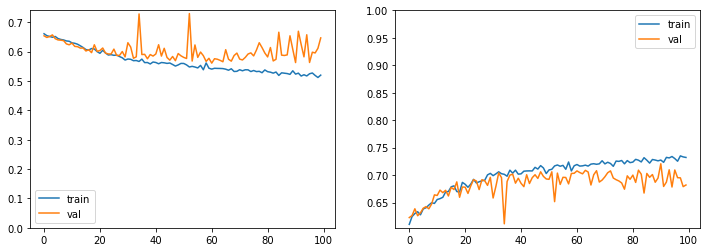

In [16]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/10-eyes_closed/', 
    'eyes_closed',
    lambda mrk: mrk.photo_reqs.eyes_closed.value
)
list_model_files.append(model_file)

#### 11. Varied Background

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.4728 - accuracy: 0.7604 - recall: 0.7490 - precision: 0.7849 - f1: 0.7455 - val_loss: 0.4031 - val_accuracy: 0.7987 - val_recall: 0.8495 - val_precision: 0.7754 - val_f1: 0.8057

Epoch 00001: val_accuracy improved from -inf to 0.79867, saving model to ../models/autoencoders_requirements/varied_background_2020_03_14-21_53_58.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4186 - accuracy: 0.7900 - recall: 0.7890 - precision: 0.8048 - f1: 0.7829 - val_loss: 0.3838 - val_accuracy: 0.8137 - val_recall: 0.8486 - val_precision: 0.7976 - val_f1: 0.8177

Epoch 00002: val_accuracy improved from 0.79867 to 0.81367, saving model to ../models/autoencoders_requirements/varied_background_2020_03_14-21_53_58.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4042 - accuracy: 0.7939 - recall: 0.7966 - precisio

7000/7000 [==============================] - 15s 2ms/step - loss: 0.3297 - accuracy: 0.8411 - recall: 0.8346 - precision: 0.8479 - f1: 0.8354 - val_loss: 0.3704 - val_accuracy: 0.8073 - val_recall: 0.6834 - val_precision: 0.9133 - val_f1: 0.7760

Epoch 00024: val_accuracy did not improve from 0.85233
Epoch 25/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3338 - accuracy: 0.8383 - recall: 0.8339 - precision: 0.8452 - f1: 0.8337 - val_loss: 0.3157 - val_accuracy: 0.8507 - val_recall: 0.8793 - val_precision: 0.8358 - val_f1: 0.8529

Epoch 00025: val_accuracy did not improve from 0.85233
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3288 - accuracy: 0.8414 - recall: 0.8377 - precision: 0.8455 - f1: 0.8362 - val_loss: 0.3204 - val_accuracy: 0.8530 - val_recall: 0.8224 - val_precision: 0.8834 - val_f1: 0.8476

Epoch 00026: val_accuracy improved from 0.85233 to 0.85300, saving model to ../models/autoencoders_requirements/varied_back

7000/7000 [==============================] - 15s 2ms/step - loss: 0.2828 - accuracy: 0.8607 - recall: 0.8587 - precision: 0.8647 - f1: 0.8565 - val_loss: 0.3020 - val_accuracy: 0.8667 - val_recall: 0.8571 - val_precision: 0.8784 - val_f1: 0.8640

Epoch 00073: val_accuracy did not improve from 0.87267
Epoch 74/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2810 - accuracy: 0.8621 - recall: 0.8575 - precision: 0.8675 - f1: 0.8578 - val_loss: 0.2858 - val_accuracy: 0.8657 - val_recall: 0.8350 - val_precision: 0.8944 - val_f1: 0.8597

Epoch 00074: val_accuracy did not improve from 0.87267
Epoch 75/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2805 - accuracy: 0.8639 - recall: 0.8636 - precision: 0.8683 - f1: 0.8595 - val_loss: 0.3324 - val_accuracy: 0.8443 - val_recall: 0.7666 - val_precision: 0.9117 - val_f1: 0.8280

Epoch 00075: val_accuracy did not improve from 0.87267
Epoch 76/100
7000/7000 [==============================] - 15s 2ms/st

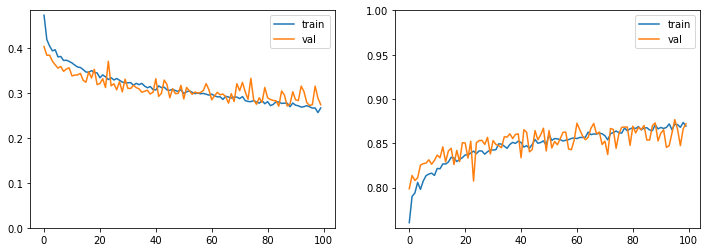

In [17]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/11-varied_bgd/', 
    'varied_background',
    lambda mrk: mrk.photo_reqs.varied_background.value
)
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.6067 - accuracy: 0.6993 - recall: 0.6975 - precision: 0.7080 - f1: 0.6925 - val_loss: 0.5834 - val_accuracy: 0.7123 - val_recall: 0.7071 - val_precision: 0.7144 - val_f1: 0.7039

Epoch 00001: val_accuracy improved from -inf to 0.71233, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_14-22_20_51.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5902 - accuracy: 0.7223 - recall: 0.6978 - precision: 0.7371 - f1: 0.7099 - val_loss: 0.5804 - val_accuracy: 0.7290 - val_recall: 0.6526 - val_precision: 0.7735 - val_f1: 0.6999

Epoch 00002: val_accuracy improved from 0.71233 to 0.72900, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_14-22_20_51.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5897 - accuracy: 0.7194 - recall: 0.6969 - precision: 0.7


Epoch 00050: val_accuracy did not improve from 0.74300
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5499 - accuracy: 0.7433 - recall: 0.6864 - precision: 0.7740 - f1: 0.7224 - val_loss: 0.5821 - val_accuracy: 0.7200 - val_recall: 0.7443 - val_precision: 0.7103 - val_f1: 0.7197

Epoch 00051: val_accuracy did not improve from 0.74300
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5490 - accuracy: 0.7437 - recall: 0.6906 - precision: 0.7702 - f1: 0.7225 - val_loss: 0.5720 - val_accuracy: 0.7250 - val_recall: 0.6503 - val_precision: 0.7650 - val_f1: 0.6959

Epoch 00052: val_accuracy did not improve from 0.74300
Epoch 53/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5495 - accuracy: 0.7419 - recall: 0.6945 - precision: 0.7697 - f1: 0.7238 - val_loss: 0.5749 - val_accuracy: 0.7293 - val_recall: 0.6764 - val_precision: 0.7572 - val_f1: 0.7068

Epoch 00053: val_accuracy did not improve from 0.74300

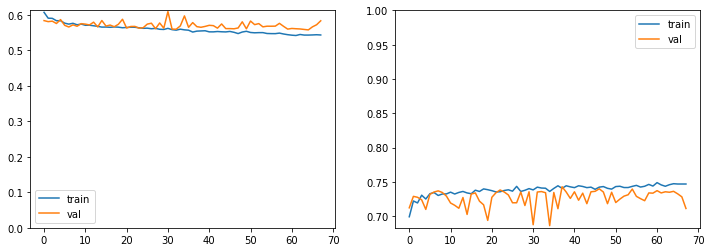

In [18]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/12-roll_pitch_yaw/', 
    'roll_pitch_yaw',
    lambda mrk: mrk.photo_reqs.roll_pitch_yaw.value
)
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.6224 - accuracy: 0.6576 - recall: 0.6671 - precision: 0.6730 - f1: 0.6394 - val_loss: 0.5854 - val_accuracy: 0.7043 - val_recall: 0.8817 - val_precision: 0.6494 - val_f1: 0.7431

Epoch 00001: val_accuracy improved from -inf to 0.70433, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_14-22_39_42.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5756 - accuracy: 0.6921 - recall: 0.7564 - precision: 0.6748 - f1: 0.6981 - val_loss: 0.5563 - val_accuracy: 0.7053 - val_recall: 0.6926 - val_precision: 0.7121 - val_f1: 0.6940

Epoch 00002: val_accuracy improved from 0.70433 to 0.70533, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_14-22_39_42.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5585 - accuracy: 0.7081 - recall: 0.7

7000/7000 [==============================] - 15s 2ms/step - loss: 0.4098 - accuracy: 0.7983 - recall: 0.7999 - precision: 0.7991 - f1: 0.7931 - val_loss: 0.4335 - val_accuracy: 0.7730 - val_recall: 0.8270 - val_precision: 0.7466 - val_f1: 0.7799

Epoch 00048: val_accuracy did not improve from 0.78467
Epoch 49/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4149 - accuracy: 0.7954 - recall: 0.8039 - precision: 0.7946 - f1: 0.7917 - val_loss: 0.4547 - val_accuracy: 0.7747 - val_recall: 0.7712 - val_precision: 0.7756 - val_f1: 0.7671

Epoch 00049: val_accuracy did not improve from 0.78467
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4133 - accuracy: 0.8031 - recall: 0.8059 - precision: 0.8060 - f1: 0.7970 - val_loss: 0.4336 - val_accuracy: 0.7817 - val_recall: 0.8064 - val_precision: 0.7673 - val_f1: 0.7813

Epoch 00050: val_accuracy did not improve from 0.78467
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/st


Epoch 00073: val_accuracy did not improve from 0.78633
Epoch 74/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3917 - accuracy: 0.8093 - recall: 0.8140 - precision: 0.8097 - f1: 0.8044 - val_loss: 0.4434 - val_accuracy: 0.7780 - val_recall: 0.8311 - val_precision: 0.7506 - val_f1: 0.7836

Epoch 00074: val_accuracy did not improve from 0.78633
Epoch 75/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3942 - accuracy: 0.8127 - recall: 0.8183 - precision: 0.8113 - f1: 0.8087 - val_loss: 0.4245 - val_accuracy: 0.7903 - val_recall: 0.8009 - val_precision: 0.7810 - val_f1: 0.7858

Epoch 00075: val_accuracy improved from 0.78633 to 0.79033, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_14-22_39_42.h5
Epoch 76/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3941 - accuracy: 0.8109 - recall: 0.8126 - precision: 0.8112 - f1: 0.8052 - val_loss: 0.4357 - val_accuracy: 0.7837 - val_recall

7000/7000 [==============================] - 15s 2ms/step - loss: 0.3805 - accuracy: 0.8204 - recall: 0.8172 - precision: 0.8212 - f1: 0.8136 - val_loss: 0.4323 - val_accuracy: 0.7820 - val_recall: 0.8032 - val_precision: 0.7709 - val_f1: 0.7812

Epoch 00099: val_accuracy did not improve from 0.79667
Epoch 100/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3851 - accuracy: 0.8197 - recall: 0.8179 - precision: 0.8272 - f1: 0.8148 - val_loss: 0.4672 - val_accuracy: 0.7653 - val_recall: 0.8228 - val_precision: 0.7374 - val_f1: 0.7719

Epoch 00100: val_accuracy did not improve from 0.79667
 Final Accuracy:  76.53%
Final F-measure:  77.81%
[[1062  438]
 [ 266 1234]]
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      1500
           1       0.74      0.82      0.78      1500

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.76      3000
weighted avg       0.77      0.77

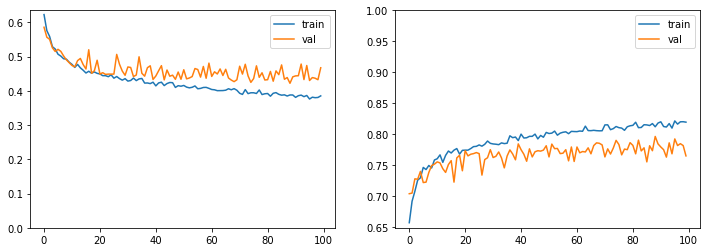

In [19]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/13-flash_reflection_on_skin/', 
    'flash_reflection_on_skin',
    lambda mrk: mrk.photo_reqs.flash_reflection_on_skin.value
)
list_model_files.append(model_file)

#### 14. Red Eyes 

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.6553 - accuracy: 0.6147 - recall: 0.4585 - precision: 0.6889 - f1: 0.5262 - val_loss: 0.6407 - val_accuracy: 0.6287 - val_recall: 0.4836 - val_precision: 0.6878 - val_f1: 0.5588

Epoch 00001: val_accuracy improved from -inf to 0.62867, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_14-23_06_30.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6438 - accuracy: 0.6304 - recall: 0.4713 - precision: 0.7037 - f1: 0.5508 - val_loss: 0.6529 - val_accuracy: 0.6210 - val_recall: 0.3603 - val_precision: 0.7618 - val_f1: 0.4783

Epoch 00002: val_accuracy did not improve from 0.62867
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6411 - accuracy: 0.6324 - recall: 0.4764 - precision: 0.7074 - f1: 0.5517 - val_loss: 0.6353 - val_accuracy: 0.6470 - val_recall: 0.5033 - val_precision: 0.71

7000/7000 [==============================] - 15s 2ms/step - loss: 0.5464 - accuracy: 0.7161 - recall: 0.6892 - precision: 0.7356 - f1: 0.7004 - val_loss: 0.5496 - val_accuracy: 0.7210 - val_recall: 0.6914 - val_precision: 0.7398 - val_f1: 0.7070

Epoch 00049: val_accuracy improved from 0.72033 to 0.72100, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_14-23_06_30.h5
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5439 - accuracy: 0.7236 - recall: 0.7038 - precision: 0.7373 - f1: 0.7102 - val_loss: 0.6246 - val_accuracy: 0.6740 - val_recall: 0.7052 - val_precision: 0.6686 - val_f1: 0.6780

Epoch 00050: val_accuracy did not improve from 0.72100
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5462 - accuracy: 0.7229 - recall: 0.7012 - precision: 0.7432 - f1: 0.7088 - val_loss: 0.6093 - val_accuracy: 0.6703 - val_recall: 0.8044 - val_precision: 0.6381 - val_f1: 0.7038

Epoch 00051: val_accuracy did not 


Epoch 00074: val_accuracy did not improve from 0.72100
Epoch 75/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5204 - accuracy: 0.7347 - recall: 0.7363 - precision: 0.7412 - f1: 0.7299 - val_loss: 0.5713 - val_accuracy: 0.7177 - val_recall: 0.6348 - val_precision: 0.7696 - val_f1: 0.6866

Epoch 00075: val_accuracy did not improve from 0.72100
Epoch 76/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5243 - accuracy: 0.7317 - recall: 0.7205 - precision: 0.7427 - f1: 0.7203 - val_loss: 0.5551 - val_accuracy: 0.7217 - val_recall: 0.6711 - val_precision: 0.7563 - val_f1: 0.7018

Epoch 00076: val_accuracy improved from 0.72100 to 0.72167, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_14-23_06_30.h5
Epoch 77/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5205 - accuracy: 0.7354 - recall: 0.7230 - precision: 0.7469 - f1: 0.7244 - val_loss: 0.5563 - val_accuracy: 0.7200 - val_recall: 0.6591 - val_p

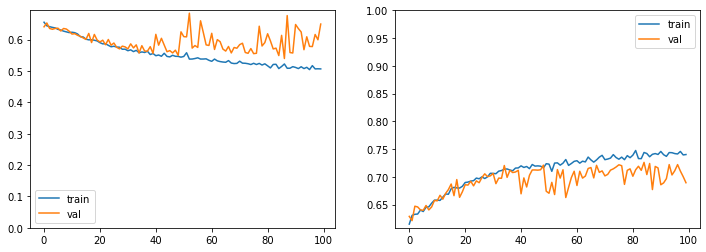

In [20]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/14-red_eyes/', 
    'red_eyes',
    lambda mrk: mrk.photo_reqs.red_eyes.value
)
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.4286 - accuracy: 0.7963 - recall: 0.7548 - precision: 0.8365 - f1: 0.7840 - val_loss: 0.3826 - val_accuracy: 0.8220 - val_recall: 0.7505 - val_precision: 0.8770 - val_f1: 0.8024

Epoch 00001: val_accuracy improved from -inf to 0.82200, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_14-23_35_02.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3681 - accuracy: 0.8267 - recall: 0.7708 - precision: 0.8765 - f1: 0.8130 - val_loss: 0.3703 - val_accuracy: 0.8310 - val_recall: 0.7360 - val_precision: 0.9098 - val_f1: 0.8070

Epoch 00002: val_accuracy improved from 0.82200 to 0.83100, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_14-23_35_02.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3608 - accuracy: 0.8310 - recall: 0.7745 - prec

7000/7000 [==============================] - 15s 2ms/step - loss: 0.2715 - accuracy: 0.8793 - recall: 0.8557 - precision: 0.9005 - f1: 0.8731 - val_loss: 0.3059 - val_accuracy: 0.8643 - val_recall: 0.8691 - val_precision: 0.8644 - val_f1: 0.8629

Epoch 00024: val_accuracy did not improve from 0.88200
Epoch 25/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2752 - accuracy: 0.8814 - recall: 0.8546 - precision: 0.9058 - f1: 0.8749 - val_loss: 0.2929 - val_accuracy: 0.8743 - val_recall: 0.8487 - val_precision: 0.8963 - val_f1: 0.8676

Epoch 00025: val_accuracy did not improve from 0.88200
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2704 - accuracy: 0.8834 - recall: 0.8616 - precision: 0.9060 - f1: 0.8776 - val_loss: 0.2869 - val_accuracy: 0.8730 - val_recall: 0.8215 - val_precision: 0.9184 - val_f1: 0.8630

Epoch 00026: val_accuracy did not improve from 0.88200
Epoch 27/100
7000/7000 [==============================] - 15s 2ms/st

7000/7000 [==============================] - 15s 2ms/step - loss: 0.2128 - accuracy: 0.9146 - recall: 0.9026 - precision: 0.9238 - f1: 0.9104 - val_loss: 0.2647 - val_accuracy: 0.8890 - val_recall: 0.8440 - val_precision: 0.9302 - val_f1: 0.8814

Epoch 00074: val_accuracy did not improve from 0.90500
Epoch 75/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2178 - accuracy: 0.9069 - recall: 0.8951 - precision: 0.9199 - f1: 0.9033 - val_loss: 0.2834 - val_accuracy: 0.8813 - val_recall: 0.8064 - val_precision: 0.9510 - val_f1: 0.8691

Epoch 00075: val_accuracy did not improve from 0.90500
Epoch 76/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2183 - accuracy: 0.9093 - recall: 0.9010 - precision: 0.9179 - f1: 0.9051 - val_loss: 0.2887 - val_accuracy: 0.8917 - val_recall: 0.8413 - val_precision: 0.9365 - val_f1: 0.8829

Epoch 00076: val_accuracy did not improve from 0.90500
Epoch 77/100
7000/7000 [==============================] - 15s 2ms/st

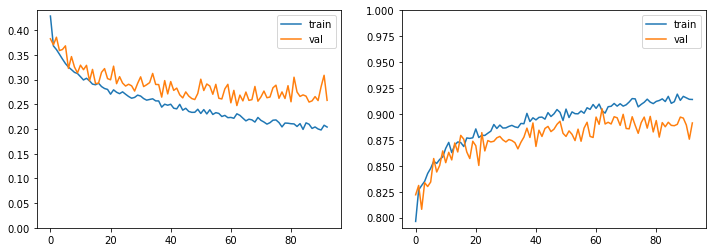

In [21]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/15-shadows_behind_head/', 
    'shadows_behind_head',
    lambda mrk: mrk.photo_reqs.shadows_behind_head.value
)
list_model_files.append(model_file)

#### 16. Shadows Across Face

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.5946 - accuracy: 0.6620 - recall: 0.6214 - precision: 0.6949 - f1: 0.6304 - val_loss: 0.5748 - val_accuracy: 0.6840 - val_recall: 0.6366 - val_precision: 0.7047 - val_f1: 0.6623

Epoch 00001: val_accuracy improved from -inf to 0.68400, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_15-00_01_25.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5662 - accuracy: 0.6921 - recall: 0.6802 - precision: 0.7054 - f1: 0.6786 - val_loss: 0.5722 - val_accuracy: 0.6857 - val_recall: 0.5537 - val_precision: 0.7491 - val_f1: 0.6288

Epoch 00002: val_accuracy improved from 0.68400 to 0.68567, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_15-00_01_25.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5607 - accuracy: 0.7014 - recall: 0.6992 - prec

7000/7000 [==============================] - 15s 2ms/step - loss: 0.4388 - accuracy: 0.7910 - recall: 0.8017 - precision: 0.7908 - f1: 0.7897 - val_loss: 0.4649 - val_accuracy: 0.7797 - val_recall: 0.7407 - val_precision: 0.8021 - val_f1: 0.7650

Epoch 00048: val_accuracy improved from 0.77800 to 0.77967, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_15-00_01_25.h5
Epoch 49/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4381 - accuracy: 0.7911 - recall: 0.7916 - precision: 0.7933 - f1: 0.7850 - val_loss: 0.5119 - val_accuracy: 0.7403 - val_recall: 0.7561 - val_precision: 0.7304 - val_f1: 0.7386

Epoch 00049: val_accuracy did not improve from 0.77967
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4388 - accuracy: 0.7889 - recall: 0.7885 - precision: 0.7966 - f1: 0.7833 - val_loss: 0.4762 - val_accuracy: 0.7683 - val_recall: 0.7437 - val_precision: 0.7839 - val_f1: 0.7566

Epoch 00050: val_accura


Epoch 00072: val_accuracy did not improve from 0.79000
Epoch 73/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4227 - accuracy: 0.7963 - recall: 0.7988 - precision: 0.7994 - f1: 0.7918 - val_loss: 0.4727 - val_accuracy: 0.7673 - val_recall: 0.7542 - val_precision: 0.7743 - val_f1: 0.7595

Epoch 00073: val_accuracy did not improve from 0.79000
Epoch 74/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4173 - accuracy: 0.8059 - recall: 0.8068 - precision: 0.8105 - f1: 0.8017 - val_loss: 0.4637 - val_accuracy: 0.7840 - val_recall: 0.7675 - val_precision: 0.7910 - val_f1: 0.7744

Epoch 00074: val_accuracy did not improve from 0.79000
Epoch 75/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4221 - accuracy: 0.8020 - recall: 0.7992 - precision: 0.8068 - f1: 0.7958 - val_loss: 0.4737 - val_accuracy: 0.7733 - val_recall: 0.7344 - val_precision: 0.7957 - val_f1: 0.7593

Epoch 00075: val_accuracy did not improve from 0.79000


Epoch 00098: val_accuracy did not improve from 0.79100
Epoch 99/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4082 - accuracy: 0.8113 - recall: 0.8088 - precision: 0.8180 - f1: 0.8069 - val_loss: 0.4499 - val_accuracy: 0.7930 - val_recall: 0.7554 - val_precision: 0.8150 - val_f1: 0.7790

Epoch 00099: val_accuracy improved from 0.79100 to 0.79300, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_15-00_01_25.h5
Epoch 100/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4058 - accuracy: 0.8126 - recall: 0.8182 - precision: 0.8135 - f1: 0.8088 - val_loss: 0.4447 - val_accuracy: 0.7973 - val_recall: 0.7615 - val_precision: 0.8197 - val_f1: 0.7847

Epoch 00100: val_accuracy improved from 0.79300 to 0.79733, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_15-00_01_25.h5
 Final Accuracy:  79.73%
Final F-measure:  78.95%
[[1252  248]
 [ 360 1140]]
              precision    recall  f

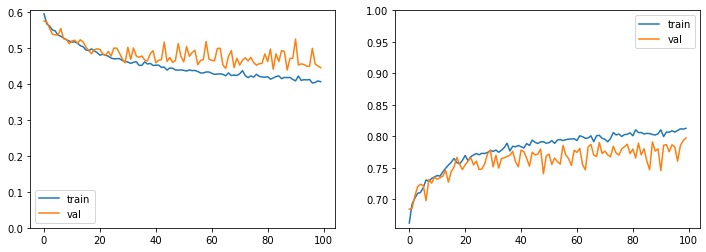

In [22]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/16-shadows_across_face/', 
    'shadows_across_face',
    lambda mrk: mrk.photo_reqs.shadows_across_face.value
)
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.5709 - accuracy: 0.6739 - recall: 0.4943 - precision: 0.7933 - f1: 0.5916 - val_loss: 0.5767 - val_accuracy: 0.6720 - val_recall: 0.3819 - val_precision: 0.9058 - val_f1: 0.5257

Epoch 00001: val_accuracy improved from -inf to 0.67200, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_15-00_30_43.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5488 - accuracy: 0.6936 - recall: 0.5350 - precision: 0.8014 - f1: 0.6274 - val_loss: 0.5622 - val_accuracy: 0.6837 - val_recall: 0.4837 - val_precision: 0.8009 - val_f1: 0.5951

Epoch 00002: val_accuracy improved from 0.67200 to 0.68367, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_15-00_30_43.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5397 - accuracy: 0.7009 - recall: 0.5742 - precis

7000/7000 [==============================] - 15s 2ms/step - loss: 0.3786 - accuracy: 0.8240 - recall: 0.7867 - precision: 0.8658 - f1: 0.8112 - val_loss: 0.5332 - val_accuracy: 0.7380 - val_recall: 0.4948 - val_precision: 0.9516 - val_f1: 0.6436

Epoch 00024: val_accuracy did not improve from 0.78567
Epoch 25/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3707 - accuracy: 0.8297 - recall: 0.7901 - precision: 0.8674 - f1: 0.8167 - val_loss: 0.5022 - val_accuracy: 0.7630 - val_recall: 0.5684 - val_precision: 0.9227 - val_f1: 0.6973

Epoch 00025: val_accuracy did not improve from 0.78567
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3710 - accuracy: 0.8263 - recall: 0.7848 - precision: 0.8666 - f1: 0.8127 - val_loss: 0.4792 - val_accuracy: 0.7700 - val_recall: 0.5754 - val_precision: 0.9330 - val_f1: 0.7059

Epoch 00026: val_accuracy did not improve from 0.78567
Epoch 27/100
7000/7000 [==============================] - 15s 2ms/st


Epoch 00049: val_accuracy did not improve from 0.78700
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3177 - accuracy: 0.8531 - recall: 0.8247 - precision: 0.8817 - f1: 0.8442 - val_loss: 0.5322 - val_accuracy: 0.7693 - val_recall: 0.5657 - val_precision: 0.9431 - val_f1: 0.6995

Epoch 00050: val_accuracy did not improve from 0.78700
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3313 - accuracy: 0.8489 - recall: 0.8218 - precision: 0.8778 - f1: 0.8391 - val_loss: 0.8752 - val_accuracy: 0.6977 - val_recall: 0.4024 - val_precision: 0.9742 - val_f1: 0.5588

Epoch 00051: val_accuracy did not improve from 0.78700
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3392 - accuracy: 0.8433 - recall: 0.8131 - precision: 0.8773 - f1: 0.8305 - val_loss: 0.5624 - val_accuracy: 0.7477 - val_recall: 0.5118 - val_precision: 0.9600 - val_f1: 0.6593

Epoch 00052: val_accuracy did not improve from 0.78700

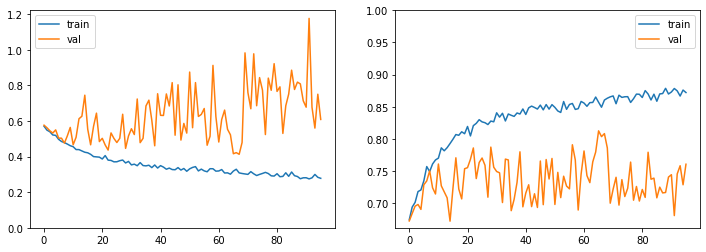

In [23]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/17-dark_tinted_lenses/', 
    'dark_tinted_lenses',
    lambda mrk: mrk.photo_reqs.dark_tinted_lenses.value
)
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.5898 - accuracy: 0.6741 - recall: 0.5958 - precision: 0.7172 - f1: 0.6364 - val_loss: 0.5705 - val_accuracy: 0.6977 - val_recall: 0.5581 - val_precision: 0.7780 - val_f1: 0.6409

Epoch 00001: val_accuracy improved from -inf to 0.69767, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_15-00_56_36.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5751 - accuracy: 0.6827 - recall: 0.6445 - precision: 0.7054 - f1: 0.6609 - val_loss: 0.5628 - val_accuracy: 0.6983 - val_recall: 0.5579 - val_precision: 0.7754 - val_f1: 0.6402

Epoch 00002: val_accuracy improved from 0.69767 to 0.69833, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_15-00_56_36.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5666 - accuracy: 0.6961 - recall:


Epoch 00049: val_accuracy did not improve from 0.72933
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4829 - accuracy: 0.7563 - recall: 0.7267 - precision: 0.7803 - f1: 0.7425 - val_loss: 0.5463 - val_accuracy: 0.7030 - val_recall: 0.5441 - val_precision: 0.8046 - val_f1: 0.6407

Epoch 00050: val_accuracy did not improve from 0.72933
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4845 - accuracy: 0.7537 - recall: 0.7288 - precision: 0.7730 - f1: 0.7400 - val_loss: 0.5226 - val_accuracy: 0.7223 - val_recall: 0.5828 - val_precision: 0.8142 - val_f1: 0.6705

Epoch 00051: val_accuracy did not improve from 0.72933
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4829 - accuracy: 0.7546 - recall: 0.7264 - precision: 0.7776 - f1: 0.7402 - val_loss: 0.5552 - val_accuracy: 0.7050 - val_recall: 0.4884 - val_precision: 0.8671 - val_f1: 0.6164

Epoch 00052: val_accuracy did not improve from 0.72933


Epoch 00075: val_accuracy did not improve from 0.74733
Epoch 76/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4588 - accuracy: 0.7640 - recall: 0.7473 - precision: 0.7773 - f1: 0.7530 - val_loss: 0.5311 - val_accuracy: 0.7207 - val_recall: 0.5754 - val_precision: 0.8169 - val_f1: 0.6665

Epoch 00076: val_accuracy did not improve from 0.74733
Epoch 77/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4540 - accuracy: 0.7713 - recall: 0.7528 - precision: 0.7861 - f1: 0.7604 - val_loss: 0.5513 - val_accuracy: 0.6977 - val_recall: 0.6292 - val_precision: 0.7286 - val_f1: 0.6692

Epoch 00077: val_accuracy did not improve from 0.74733
Epoch 78/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4582 - accuracy: 0.7687 - recall: 0.7565 - precision: 0.7841 - f1: 0.7591 - val_loss: 0.5590 - val_accuracy: 0.7173 - val_recall: 0.5252 - val_precision: 0.8570 - val_f1: 0.6422

Epoch 00078: val_accuracy did not improve from 0.74733

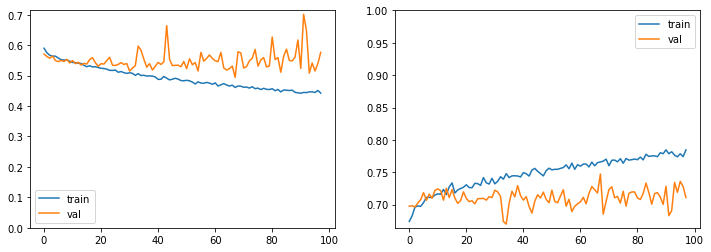

In [24]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/18-flash_reflection_on_lenses/', 
    'flash_reflection_on_lenses',
    lambda mrk: mrk.photo_reqs.flash_reflection_on_lenses.value
)
list_model_files.append(model_file)

#### 19. Frames Too Heavy

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.4569 - accuracy: 0.7850 - recall: 0.7341 - precision: 0.8348 - f1: 0.7678 - val_loss: 0.4324 - val_accuracy: 0.8090 - val_recall: 0.6532 - val_precision: 0.9506 - val_f1: 0.7675

Epoch 00001: val_accuracy improved from -inf to 0.80900, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_15-01_23_11.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3772 - accuracy: 0.8247 - recall: 0.7954 - precision: 0.8571 - f1: 0.8148 - val_loss: 0.4316 - val_accuracy: 0.8137 - val_recall: 0.6732 - val_precision: 0.9367 - val_f1: 0.7784

Epoch 00002: val_accuracy improved from 0.80900 to 0.81367, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_15-01_23_11.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3166 - accuracy: 0.8587 - recall: 0.8329 - precision:


Epoch 00024: val_accuracy did not improve from 0.93033
Epoch 25/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.1024 - accuracy: 0.9596 - recall: 0.9501 - precision: 0.9700 - f1: 0.9580 - val_loss: 0.2216 - val_accuracy: 0.9000 - val_recall: 0.8674 - val_precision: 0.9273 - val_f1: 0.8935

Epoch 00025: val_accuracy did not improve from 0.93033
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.0967 - accuracy: 0.9601 - recall: 0.9505 - precision: 0.9699 - f1: 0.9581 - val_loss: 0.1550 - val_accuracy: 0.9367 - val_recall: 0.9333 - val_precision: 0.9386 - val_f1: 0.9344

Epoch 00026: val_accuracy improved from 0.93033 to 0.93667, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_15-01_23_11.h5
Epoch 27/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1057 - accuracy: 0.9554 - recall: 0.9512 - precision: 0.9621 - f1: 0.9538 - val_loss: 0.2457 - val_accuracy: 0.8857 - val_recall: 0.8465

7000/7000 [==============================] - 15s 2ms/step - loss: 0.0749 - accuracy: 0.9733 - recall: 0.9706 - precision: 0.9774 - f1: 0.9724 - val_loss: 0.2189 - val_accuracy: 0.9177 - val_recall: 0.9454 - val_precision: 0.8955 - val_f1: 0.9176

Epoch 00050: val_accuracy did not improve from 0.96733
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.0641 - accuracy: 0.9749 - recall: 0.9716 - precision: 0.9783 - f1: 0.9737 - val_loss: 0.1486 - val_accuracy: 0.9447 - val_recall: 0.9815 - val_precision: 0.9148 - val_f1: 0.9455

Epoch 00051: val_accuracy did not improve from 0.96733
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.0791 - accuracy: 0.9696 - recall: 0.9675 - precision: 0.9718 - f1: 0.9677 - val_loss: 0.1079 - val_accuracy: 0.9557 - val_recall: 0.9552 - val_precision: 0.9569 - val_f1: 0.9546

Epoch 00052: val_accuracy did not improve from 0.96733
Epoch 53/100
7000/7000 [==============================] - 15s 2ms/st


Epoch 00075: val_accuracy did not improve from 0.97167
Epoch 76/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.0553 - accuracy: 0.9800 - recall: 0.9753 - precision: 0.9857 - f1: 0.9796 - val_loss: 0.1025 - val_accuracy: 0.9567 - val_recall: 0.9664 - val_precision: 0.9488 - val_f1: 0.9563

Epoch 00076: val_accuracy did not improve from 0.97167
Epoch 77/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.0529 - accuracy: 0.9811 - recall: 0.9789 - precision: 0.9851 - f1: 0.9811 - val_loss: 0.2537 - val_accuracy: 0.8887 - val_recall: 0.9912 - val_precision: 0.8227 - val_f1: 0.8966

Epoch 00077: val_accuracy did not improve from 0.97167
Epoch 78/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.0532 - accuracy: 0.9807 - recall: 0.9775 - precision: 0.9850 - f1: 0.9804 - val_loss: 0.1032 - val_accuracy: 0.9617 - val_recall: 0.9565 - val_precision: 0.9668 - val_f1: 0.9606

Epoch 00078: val_accuracy did not improve from 0.97167

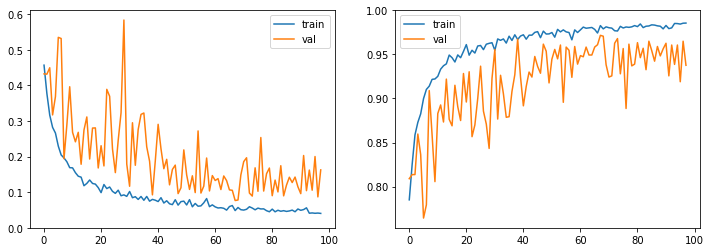

In [25]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/19-frames_too_heavy/', 
    'frames_too_heavy',
    lambda mrk: mrk.photo_reqs.frames_too_heavy.value
)
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.6163 - accuracy: 0.6659 - recall: 0.5796 - precision: 0.7212 - f1: 0.6234 - val_loss: 0.5998 - val_accuracy: 0.6630 - val_recall: 0.4565 - val_precision: 0.7793 - val_f1: 0.5654

Epoch 00001: val_accuracy improved from -inf to 0.66300, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_15-01_49_52.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6007 - accuracy: 0.6799 - recall: 0.6070 - precision: 0.7233 - f1: 0.6465 - val_loss: 0.6056 - val_accuracy: 0.6580 - val_recall: 0.4399 - val_precision: 0.7850 - val_f1: 0.5540

Epoch 00002: val_accuracy did not improve from 0.66300
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6030 - accuracy: 0.6837 - recall: 0.6216 - precision: 0.7262 - f1: 0.6564 - val_loss: 0.5865 - val_accuracy: 0.6903 - val_recall: 0.7087 - val_prec


Epoch 00022: val_accuracy did not improve from 0.72733
Epoch 23/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5576 - accuracy: 0.7236 - recall: 0.6531 - precision: 0.7646 - f1: 0.6966 - val_loss: 0.5540 - val_accuracy: 0.7193 - val_recall: 0.6264 - val_precision: 0.7723 - val_f1: 0.6840

Epoch 00023: val_accuracy did not improve from 0.72733
Epoch 24/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5588 - accuracy: 0.7190 - recall: 0.6396 - precision: 0.7707 - f1: 0.6888 - val_loss: 0.5527 - val_accuracy: 0.7227 - val_recall: 0.6034 - val_precision: 0.7955 - val_f1: 0.6782

Epoch 00024: val_accuracy did not improve from 0.72733
Epoch 25/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5528 - accuracy: 0.7201 - recall: 0.6463 - precision: 0.7620 - f1: 0.6905 - val_loss: 0.5570 - val_accuracy: 0.7080 - val_recall: 0.7059 - val_precision: 0.7090 - val_f1: 0.7003

Epoch 00025: val_accuracy did not improve from 0.72733

7000/7000 [==============================] - 15s 2ms/step - loss: 0.5316 - accuracy: 0.7409 - recall: 0.6698 - precision: 0.7875 - f1: 0.7149 - val_loss: 0.5581 - val_accuracy: 0.7217 - val_recall: 0.6805 - val_precision: 0.7397 - val_f1: 0.7015

Epoch 00048: val_accuracy did not improve from 0.73600
Epoch 49/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5332 - accuracy: 0.7369 - recall: 0.6582 - precision: 0.7821 - f1: 0.7070 - val_loss: 0.5486 - val_accuracy: 0.7227 - val_recall: 0.6380 - val_precision: 0.7721 - val_f1: 0.6892

Epoch 00049: val_accuracy did not improve from 0.73600
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5300 - accuracy: 0.7350 - recall: 0.6651 - precision: 0.7837 - f1: 0.7077 - val_loss: 0.5725 - val_accuracy: 0.7147 - val_recall: 0.7250 - val_precision: 0.7093 - val_f1: 0.7103

Epoch 00050: val_accuracy did not improve from 0.73600
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/st

7000/7000 [==============================] - 15s 2ms/step - loss: 0.5044 - accuracy: 0.7539 - recall: 0.6980 - precision: 0.7948 - f1: 0.7338 - val_loss: 0.5694 - val_accuracy: 0.7513 - val_recall: 0.6746 - val_precision: 0.7960 - val_f1: 0.7225

Epoch 00098: val_accuracy improved from 0.74333 to 0.75133, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_15-01_49_52.h5
Epoch 99/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5042 - accuracy: 0.7527 - recall: 0.6903 - precision: 0.7939 - f1: 0.7300 - val_loss: 0.5454 - val_accuracy: 0.7417 - val_recall: 0.6247 - val_precision: 0.8167 - val_f1: 0.6999

Epoch 00099: val_accuracy did not improve from 0.75133
Epoch 100/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4999 - accuracy: 0.7539 - recall: 0.6837 - precision: 0.8027 - f1: 0.7285 - val_loss: 0.5573 - val_accuracy: 0.7223 - val_recall: 0.6883 - val_precision: 0.7384 - val_f1: 0.7046

Epoch 00100: val_accur

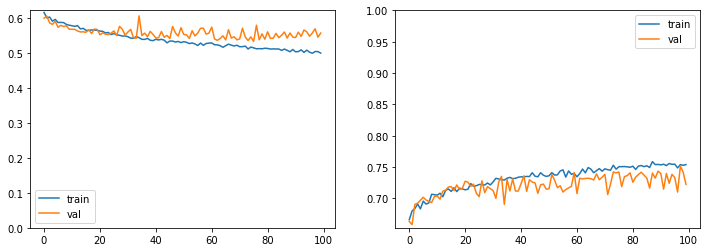

In [26]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/20-frame_covering_eyes/', 
    'frame_covering_eyes',
    lambda mrk: mrk.photo_reqs.frame_covering_eyes.value  
)
list_model_files.append(model_file)

#### 21. Hat/cap 

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 17s 2ms/step - loss: 0.5900 - accuracy: 0.6786 - recall: 0.6540 - precision: 0.7043 - f1: 0.6612 - val_loss: 0.5857 - val_accuracy: 0.6673 - val_recall: 0.6244 - val_precision: 0.6841 - val_f1: 0.6436

Epoch 00001: val_accuracy improved from -inf to 0.66733, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_15-02_17_03.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5497 - accuracy: 0.7113 - recall: 0.6656 - precision: 0.7438 - f1: 0.6892 - val_loss: 0.5653 - val_accuracy: 0.6927 - val_recall: 0.5379 - val_precision: 0.7808 - val_f1: 0.6276

Epoch 00002: val_accuracy improved from 0.66733 to 0.69267, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_15-02_17_03.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5331 - accuracy: 0.7276 - recall: 0.6701 - precision: 0.7643 - f1: 0.70


Epoch 00023: val_accuracy did not improve from 0.76967
Epoch 24/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4189 - accuracy: 0.7894 - recall: 0.7578 - precision: 0.8180 - f1: 0.7775 - val_loss: 0.5442 - val_accuracy: 0.7433 - val_recall: 0.5446 - val_precision: 0.9085 - val_f1: 0.6712

Epoch 00024: val_accuracy did not improve from 0.76967
Epoch 25/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4230 - accuracy: 0.7904 - recall: 0.7556 - precision: 0.8180 - f1: 0.7760 - val_loss: 0.4640 - val_accuracy: 0.7683 - val_recall: 0.6532 - val_precision: 0.8507 - val_f1: 0.7313

Epoch 00025: val_accuracy did not improve from 0.76967
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.4146 - accuracy: 0.7920 - recall: 0.7544 - precision: 0.8247 - f1: 0.7773 - val_loss: 0.5778 - val_accuracy: 0.7337 - val_recall: 0.5310 - val_precision: 0.9031 - val_f1: 0.6579

Epoch 00026: val_accuracy did not improve from 0.76967


Epoch 00048: val_accuracy did not improve from 0.78933
Epoch 49/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3807 - accuracy: 0.8130 - recall: 0.7766 - precision: 0.8421 - f1: 0.7994 - val_loss: 0.5240 - val_accuracy: 0.7597 - val_recall: 0.5700 - val_precision: 0.9273 - val_f1: 0.6956

Epoch 00049: val_accuracy did not improve from 0.78933
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3809 - accuracy: 0.8130 - recall: 0.7799 - precision: 0.8388 - f1: 0.7999 - val_loss: 0.4845 - val_accuracy: 0.7827 - val_recall: 0.6387 - val_precision: 0.9010 - val_f1: 0.7403

Epoch 00050: val_accuracy did not improve from 0.78933
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3715 - accuracy: 0.8183 - recall: 0.7833 - precision: 0.8416 - f1: 0.8049 - val_loss: 0.4370 - val_accuracy: 0.7920 - val_recall: 0.7145 - val_precision: 0.8462 - val_f1: 0.7683

Epoch 00051: val_accuracy improved from 0.78933 to 0.7


Epoch 00074: val_accuracy did not improve from 0.79200
Epoch 75/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3640 - accuracy: 0.8239 - recall: 0.7868 - precision: 0.8608 - f1: 0.8128 - val_loss: 0.4982 - val_accuracy: 0.7753 - val_recall: 0.6081 - val_precision: 0.9195 - val_f1: 0.7237

Epoch 00075: val_accuracy did not improve from 0.79200
Epoch 76/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3567 - accuracy: 0.8293 - recall: 0.7935 - precision: 0.8572 - f1: 0.8162 - val_loss: 0.5035 - val_accuracy: 0.7783 - val_recall: 0.6264 - val_precision: 0.9005 - val_f1: 0.7322

Epoch 00076: val_accuracy did not improve from 0.79200
Epoch 77/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3532 - accuracy: 0.8297 - recall: 0.7916 - precision: 0.8634 - f1: 0.8175 - val_loss: 0.4898 - val_accuracy: 0.7840 - val_recall: 0.6390 - val_precision: 0.9061 - val_f1: 0.7410

Epoch 00077: val_accuracy did not improve from 0.79200

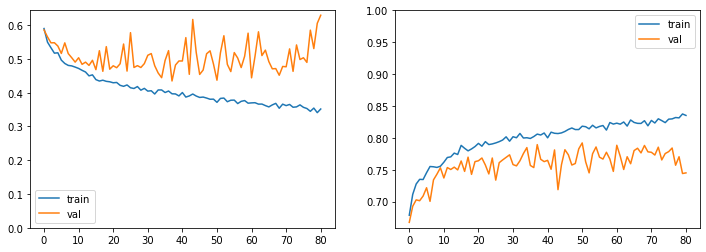

In [27]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/21-hat_cap/', 
    'hat_cap',
    lambda mrk: mrk.photo_reqs.hat_cap.value
)
list_model_files.append(model_file)

#### *22. Veil Over Face*

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.3786 - accuracy: 0.8397 - recall: 0.7762 - precision: 0.8915 - f1: 0.8207 - val_loss: 0.3551 - val_accuracy: 0.8613 - val_recall: 0.7811 - val_precision: 0.9299 - val_f1: 0.8447

Epoch 00001: val_accuracy improved from -inf to 0.86133, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_15-02_39_23.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3141 - accuracy: 0.8711 - recall: 0.8471 - precision: 0.8942 - f1: 0.8648 - val_loss: 0.5066 - val_accuracy: 0.8040 - val_recall: 0.6522 - val_precision: 0.9383 - val_f1: 0.7632

Epoch 00002: val_accuracy did not improve from 0.86133
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3030 - accuracy: 0.8726 - recall: 0.8605 - precision: 0.8881 - f1: 0.8677 - val_loss: 0.4831 - val_accuracy: 0.8117 - val_recall: 0.6651 - val_precision


Epoch 00025: val_accuracy did not improve from 0.91400
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1815 - accuracy: 0.9256 - recall: 0.9232 - precision: 0.9294 - f1: 0.9220 - val_loss: 0.5357 - val_accuracy: 0.8350 - val_recall: 0.6967 - val_precision: 0.9620 - val_f1: 0.8030

Epoch 00026: val_accuracy did not improve from 0.91400
Epoch 27/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1855 - accuracy: 0.9260 - recall: 0.9300 - precision: 0.9282 - f1: 0.9247 - val_loss: 0.3950 - val_accuracy: 0.8683 - val_recall: 0.7714 - val_precision: 0.9573 - val_f1: 0.8505

Epoch 00027: val_accuracy did not improve from 0.91400
Epoch 28/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1695 - accuracy: 0.9321 - recall: 0.9311 - precision: 0.9348 - f1: 0.9300 - val_loss: 0.3102 - val_accuracy: 0.8893 - val_recall: 0.8197 - val_precision: 0.9539 - val_f1: 0.8785

Epoch 00028: val_accuracy did not improve from 0.91400


Epoch 00051: val_accuracy did not improve from 0.91900
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1435 - accuracy: 0.9419 - recall: 0.9423 - precision: 0.9440 - f1: 0.9399 - val_loss: 0.3604 - val_accuracy: 0.8740 - val_recall: 0.7683 - val_precision: 0.9754 - val_f1: 0.8554

Epoch 00052: val_accuracy did not improve from 0.91900
Epoch 53/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1335 - accuracy: 0.9476 - recall: 0.9483 - precision: 0.9511 - f1: 0.9469 - val_loss: 0.3139 - val_accuracy: 0.8940 - val_recall: 0.8089 - val_precision: 0.9754 - val_f1: 0.8808

Epoch 00053: val_accuracy did not improve from 0.91900
Epoch 54/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1292 - accuracy: 0.9494 - recall: 0.9481 - precision: 0.9506 - f1: 0.9473 - val_loss: 0.2290 - val_accuracy: 0.9113 - val_recall: 0.8450 - val_precision: 0.9748 - val_f1: 0.9021

Epoch 00054: val_accuracy did not improve from 0.91900

7000/7000 [==============================] - 15s 2ms/step - loss: 0.1147 - accuracy: 0.9544 - recall: 0.9552 - precision: 0.9538 - f1: 0.9527 - val_loss: 0.2086 - val_accuracy: 0.9207 - val_recall: 0.8925 - val_precision: 0.9462 - val_f1: 0.9156

Epoch 00077: val_accuracy did not improve from 0.92767
Epoch 78/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1080 - accuracy: 0.9530 - recall: 0.9566 - precision: 0.9525 - f1: 0.9522 - val_loss: 0.1844 - val_accuracy: 0.9263 - val_recall: 0.9021 - val_precision: 0.9458 - val_f1: 0.9209

Epoch 00078: val_accuracy did not improve from 0.92767
Epoch 79/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.1089 - accuracy: 0.9543 - recall: 0.9555 - precision: 0.9553 - f1: 0.9533 - val_loss: 0.2812 - val_accuracy: 0.9013 - val_recall: 0.9193 - val_precision: 0.8856 - val_f1: 0.8992

Epoch 00079: val_accuracy did not improve from 0.92767
Epoch 80/100
7000/7000 [==============================] - 15s 2ms/st

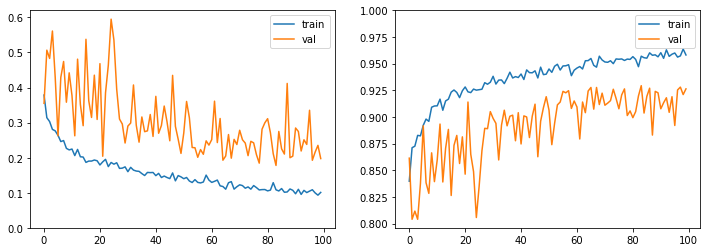

In [28]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/22-veil_over_face/', 
    'veil_over_face',
    lambda mrk: mrk.photo_reqs.veil_over_face.value 
)
list_model_files.append(model_file)

#### 23. Mouth Open 

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.6260 - accuracy: 0.6571 - recall: 0.5668 - precision: 0.7094 - f1: 0.6139 - val_loss: 0.6246 - val_accuracy: 0.6470 - val_recall: 0.4060 - val_precision: 0.7759 - val_f1: 0.5219

Epoch 00001: val_accuracy improved from -inf to 0.64700, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_15-03_06_25.h5
Epoch 2/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6081 - accuracy: 0.6763 - recall: 0.6008 - precision: 0.7159 - f1: 0.6411 - val_loss: 0.6258 - val_accuracy: 0.6557 - val_recall: 0.4253 - val_precision: 0.7764 - val_f1: 0.5402

Epoch 00002: val_accuracy improved from 0.64700 to 0.65567, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_15-03_06_25.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.6042 - accuracy: 0.6784 - recall: 0.6033 - precision: 0.7212 - f1

7000/7000 [==============================] - 15s 2ms/step - loss: 0.5316 - accuracy: 0.7260 - recall: 0.6664 - precision: 0.7581 - f1: 0.7005 - val_loss: 0.5599 - val_accuracy: 0.7083 - val_recall: 0.7089 - val_precision: 0.7046 - val_f1: 0.6997

Epoch 00049: val_accuracy did not improve from 0.72067
Epoch 50/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5373 - accuracy: 0.7254 - recall: 0.6796 - precision: 0.7575 - f1: 0.7039 - val_loss: 0.5569 - val_accuracy: 0.7163 - val_recall: 0.6619 - val_precision: 0.7352 - val_f1: 0.6898

Epoch 00050: val_accuracy did not improve from 0.72067
Epoch 51/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.5336 - accuracy: 0.7206 - recall: 0.6664 - precision: 0.7532 - f1: 0.6978 - val_loss: 0.5550 - val_accuracy: 0.7100 - val_recall: 0.7603 - val_precision: 0.6882 - val_f1: 0.7158

Epoch 00051: val_accuracy did not improve from 0.72067
Epoch 52/100
7000/7000 [==============================] - 15s 2ms/st

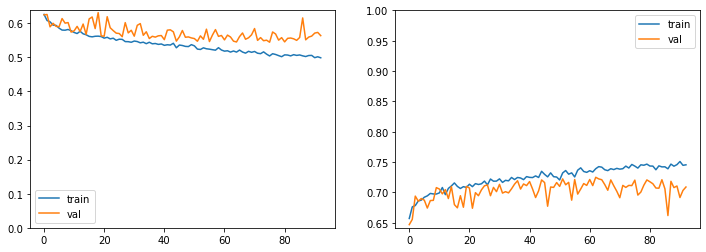

In [29]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/23-mouth_open/', 
    'mouth_open',
    lambda mrk: mrk.photo_reqs.mouth_open.value
)
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

10000 of 10000
10000 of 10000


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.3817 - accuracy: 0.8596 - recall: 0.8333 - precision: 0.8787 - f1: 0.8511 - val_loss: 0.5022 - val_accuracy: 0.8127 - val_recall: 0.6657 - val_precision: 0.9361 - val_f1: 0.7720

Epoch 00001: val_accuracy improved from -inf to 0.81267, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_15-03_31_46.h5
Epoch 2/100
7000/7000 [==============================] - 16s 2ms/step - loss: 0.3301 - accuracy: 0.8816 - recall: 0.8626 - precision: 0.8953 - f1: 0.8751 - val_loss: 0.4821 - val_accuracy: 0.8190 - val_recall: 0.6816 - val_precision: 0.9306 - val_f1: 0.7813

Epoch 00002: val_accuracy improved from 0.81267 to 0.81900, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_15-03_31_46.h5
Epoch 3/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3141 - accuracy: 0.8850


Epoch 00024: val_accuracy did not improve from 0.89267
Epoch 25/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2191 - accuracy: 0.9227 - recall: 0.8786 - precision: 0.9644 - f1: 0.9164 - val_loss: 0.3783 - val_accuracy: 0.8437 - val_recall: 0.7014 - val_precision: 0.9790 - val_f1: 0.8124

Epoch 00025: val_accuracy did not improve from 0.89267
Epoch 26/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2162 - accuracy: 0.9243 - recall: 0.8846 - precision: 0.9644 - f1: 0.9200 - val_loss: 0.3783 - val_accuracy: 0.8467 - val_recall: 0.7059 - val_precision: 0.9794 - val_f1: 0.8161

Epoch 00026: val_accuracy did not improve from 0.89267
Epoch 27/100
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2185 - accuracy: 0.9213 - recall: 0.8805 - precision: 0.9591 - f1: 0.9154 - val_loss: 0.3130 - val_accuracy: 0.8767 - val_recall: 0.7642 - val_precision: 0.9808 - val_f1: 0.8555

Epoch 00027: val_accuracy did not improve from 0.89267

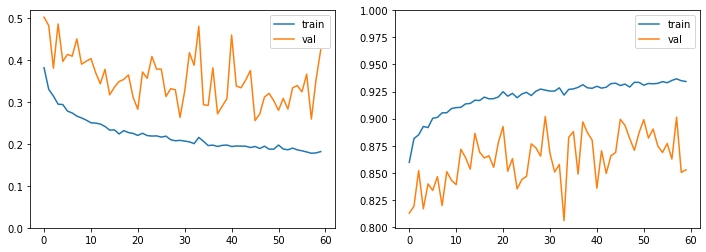

In [30]:
model_file = train_requirement_branch(
    encoder, 
    '../data/pybossa/augmentation/24-presence_of_other_faces_or_toys/', 
    'presence_of_other_faces_or_toys',
    lambda mrk: mrk.photo_reqs.presence_of_other_faces_or_toys.value
)
list_model_files.append(model_file)

# Models Merge

In [36]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_14-18_57_01.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_14-19_06_43.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_14-19_26_28.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_14-19_53_12.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_14-20_15_11.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_14-20_41_52.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_14-21_01_48.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_14-21_27_09.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_14-21_53_58.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_14-22_20_51.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_14-22_39_42.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_14-23_06_30.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_14-23_35_02.h5'


In [45]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

In [44]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [model.get_layer(model.output_names[0])(embeddings) for model in list_models]

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


ValueError: Input 0 is incompatible with layer blurred: expected axis -1 of input shape to have value 32 but got shape (None, 256)

In [ ]:
final_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
final_model.summary()

final_model.save(FOLDER_MODELS + timestamp_model_name(prefix='final_model_'))

In [ ]:
import cv2
from glob import glob

list_files = glob('../data/val/FVC/images/*')
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=(224, 224), interpolation=cv2.INTER_AREA)
im /= 255

y_pred = final_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

# Error Analysis 

In [ ]:
y_val_dec = enc.inverse_transform(y_val)
y_pred_dec = enc.inverse_transform(y_pred)

cond = (y_val_dec == -1) & (y_pred_dec == 0)
im_errors = x_val[cond]
y_true = y_val_dec[cond]
print(im_errors.shape, y_true.shape)

plot.image_batch(im_errors[:, :, :, ::-1], y_true, n_cols=5, figsize=(16, 16))